# Food Inspection Analysis

Restaurants under go food inspection to make sure the owners and managers aren't serving bad food maliciously or not. 

## Section 0: Setting the Environment

For this analysis we will be using pandas, numpy, regex, and visualization software

In [218]:
#import statements
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import nan as NA
import datetime as dt
from dateutil.parser import parse
import plotly.graph_objects as go
from matplotlib.ticker import FuncFormatter
import folium
import matplotlib
import branca
mapbox_access_token='pk.eyJ1IjoidmluZWVwYyIsImEiOiJjbHAyenJneHQwM3Z6MmpzMWprNGVlOHZqIn0.ruO39iTCN0k1bk-hFUrIYA'
data_location=r'HW6_Food Inspections Nov 2023.csv'

## Section 1: Data Processing

We first need to load the data and take alook at it so that we can figure out what we are working with and how we might need to clean it

In [8]:
# loading the data
data=pd.read_csv(data_location)
data.head()

,Establishment_id,Name,Category,Inspection_date,Inspection_results,City,State,Zip,Address_line_1,Address_line_2,...,Hot_and_cold_running_water_provided,Proper_sewage_disposal,No_bare_hand_contact,Adequate_hand_washing_facilities,Rodent_and_insects,Food_contact_surfaces_and_equipment,Inspection_type,Owner,Type,Location
0,900,LONGHORN STEAKHOUSE OF BOWIE 5174,Restaurant,05/13/2020 12:00:00 AM,------,BOWIE,MD,20716.0,4100 TOWN CENTER BLVD,------,...,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,NaN,Colleen Lyons,Food Establishments,POINT (-76.733979 38.945787)
1,16073,Anarkali Bazar,Grocery Store,03/24/2020 12:00:00 AM,Non-Compliant - Violations Observed,GREENBELT,MD,20770.0,6106 GREENBELT RD,------,...,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,Pre-Opening Inspection,YASIR RANA,Food Establishments,POINT (-76.908332 38.997396)
2,1207,PUPUSERIA MORAZAN,Fast Food - Local,05/11/2020 12:00:00 AM,------,BRENTWOOD,MD,20722.0,4309 BLADENSBURG RD,------,...,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,Food Complaint,NAPOLEON CASTRO,Food Establishments,POINT (-76.944736 38.937661)
3,3412,THE TENDER RIB & CATERING CO,Fast Food - Local,05/09/2020 12:00:00 AM,------,SUITLAND,MD,20746.0,4809 ALLENTOWN RD,------,...,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,NaN,CYNTHIA WALLACE,Food Establishments,POINT (-76.889999 38.818813)
4,16073,Anarkali Bazar,Grocery Store,03/31/2020 12:00:00 AM,Compliance Schedule - Completed,GREENBELT,MD,20770.0,6106 GREENBELT RD,------,...,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,Re-inspection,YASIR RANA,Food Establishments,POINT (-76.908332 38.997396)


This seems to be data for inspections of various eshtabishments at Prince George County. Lets find out how many inspections have been done

In [10]:
print(f'There are {len(data)} inspections')

There are 44597 inspections


The data contains almost 45000 inspections. We should clean the data before proceeding further


First we should find null values of any form and then label them. then we need figure out what to do with them. We also need to replace the data's missing value indicator with NaN

In [13]:
#Finding and replacing any string starting with hyphen with NaN 
data=data.replace('^-',NA,regex=True)


In [14]:
#finding number of null values for each column
data.isnull().sum()

Establishment_id                           0
Name                                       0
Category                                1007
Inspection_date                            0
Inspection_results                     14787
City                                      24
State                                      0
Zip                                        3
Address_line_1                             3
Address_line_2                         40084
Food_from_approved_source                  0
Food_protected_from_contamination          0
Ill_workers_restricted                     0
Proper_hand_washing                        0
Cooling_time_and_temperature               0
Cold_holding_temperature                   0
Hot_holding_temperature                    0
Cooking_time_and_temperature               0
Reheating_time_and_temperature             0
Hot_and_cold_running_water_provided        0
Proper_sewage_disposal                     0
No_bare_hand_contact                       0
Adequate_h

As there are many null values in the Inspection_results column we need to find a way to impute these details. As the various factors in a inspection arent null we can use them to impute the value of the result

In [16]:
# storing list of inspection parameters for easy use
list_of_inspection_parameters=['Food_from_approved_source','Food_protected_from_contamination','Ill_workers_restricted','Proper_hand_washing',
                               'Cooling_time_and_temperature','Cold_holding_temperature','Hot_holding_temperature','Cooking_time_and_temperature',
                               'Reheating_time_and_temperature','Hot_and_cold_running_water_provided','Proper_sewage_disposal','No_bare_hand_contact',
                               'Adequate_hand_washing_facilities','Rodent_and_insects','Food_contact_surfaces_and_equipment']
# replacing the compliance status with number to better find violations
data=data.replace({'In Compliance':0,'Out of Compliance':1})
# extracting rows where inspection result is null to find status of compliance by summing the insecption values
null_results=data[data.Inspection_results.isnull()]
impute_column_binary=null_results[list_of_inspection_parameters].sum(axis=1)
# Getting the column to impute values onto
impute_column=impute_column_binary.map(lambda x: 'Compliant' if x==0 else 'Non-Compliant - Violations Observed')
impute_column

0        Compliant
2        Compliant
3        Compliant
5        Compliant
6        Compliant
           ...    
44582    Compliant
44583    Compliant
44585    Compliant
44593    Compliant
44594    Compliant
Length: 14787, dtype: object

In [17]:
#Imputing the missing data with the data derived from analysing the violations number of the inspection
data['Inspection_results']=data['Inspection_results'].fillna(impute_column)
data.isnull().sum()

Establishment_id                           0
Name                                       0
Category                                1007
Inspection_date                            0
Inspection_results                         0
City                                      24
State                                      0
Zip                                        3
Address_line_1                             3
Address_line_2                         40084
Food_from_approved_source                  0
Food_protected_from_contamination          0
Ill_workers_restricted                     0
Proper_hand_washing                        0
Cooling_time_and_temperature               0
Cold_holding_temperature                   0
Hot_holding_temperature                    0
Cooking_time_and_temperature               0
Reheating_time_and_temperature             0
Hot_and_cold_running_water_provided        0
Proper_sewage_disposal                     0
No_bare_hand_contact                       0
Adequate_h

Now with a major source of null values imputed we can focus on other columns to clean

In [19]:
# Checking data with null addresses
data[data.Address_line_1.isnull()]

,Establishment_id,Name,Category,Inspection_date,Inspection_results,City,State,Zip,Address_line_1,Address_line_2,...,Hot_and_cold_running_water_provided,Proper_sewage_disposal,No_bare_hand_contact,Adequate_hand_washing_facilities,Rodent_and_insects,Food_contact_surfaces_and_equipment,Inspection_type,Owner,Type,Location
37001,7352,DUP -don't use this insp attached,NaN,04/16/2019 12:00:00 AM,Critical Violations observed,NaN,MD,NaN,NaN,NaN,...,0,0,0,0,1,1,Comprehensive,NaN,Food Establishments,POINT (-76.687282 38.946466)
38935,7352,DUP -don't use this insp attached,NaN,04/16/2019 12:00:00 AM,Critical Violations observed,NaN,MD,NaN,NaN,NaN,...,0,0,0,0,0,0,Comprehensive,NaN,Food Establishments,POINT (-76.687282 38.946466)
40461,7352,DUP -don't use this insp attached,NaN,04/16/2019 12:00:00 AM,Compliant,NaN,MD,NaN,NaN,NaN,...,0,0,0,0,0,0,Comprehensive,NaN,Food Establishments,POINT (-76.687282 38.946466)


Huh, I guess we can just drop this data

In [21]:
#drippoing data with do not use name
data=data.dropna(subset='Address_line_1')

With the data cleaned. We can now look for restaurant like eshtablishments. Lets see what are different kinds of eshtablihments visited by the inspectors

In [23]:
# finding the unique valus in the category 
data['Category'].unique()

array(['Restaurant', 'Grocery Store', 'Fast Food - Local', 'Carry-out',
       'Convenience Store', 'Seafood', 'Fast Food - Chain', nan,
       'Institution', 'Grocery Store- Medium', 'Meat/Poultry Market',
       'Gas Station Store', 'Membership Warehouse', 'Ice Cream', 'Casino',
       'Public School', 'Coffee Shop', '@Full Service', 'Specialty Store',
       'Hotel', 'Dollar Store', 'Fast Food', 'Full Service',
       'Private School', 'Stadium/Amusement Park', 'Bakery',
       'Multiple Facilities', 'College/University', 'Catering Only',
       'Snack Bar/Concession Stand', 'Limited Service',
       'Pre-Packaged Only', 'Deli', 'Bar/Tavern/Lounge',
       'Health Care Facility', 'Buffet', 'After School Supper Program',
       'Private Club', 'Cafeteria', 'Night Club', 'Grocery Store - Large',
       'Church/Temple/Mosque', 'Fire/Community Hall',
       'Banquet Hall/Ballroom', 'Senior Nutrition Program',
       'Diet/Nutrition Site', 'Bakery/Catering', '@Fast Food-Do Not Use',
    

From this we can see there are quite a lot of types of eshtablishments but only some of them are restaurant like. Namely 
<li>Restaurant </li>
<li>Fast Food - Local</li>
<li>Fast Food - Chain</li>
<li>Carry-out</li>
<li>Seafood</li>
<li>Ice Cream</li>
<li>Coffee Shop</li>
<li>@Full Service</li>
<li>Hotel</li>
<li>Fast Food</li>
<li>Full Service</li>
<li>Bakery</li>
<li>Limited Service</li>
<li>Deli</li>
<li>Bar/Tavern/Lounge</li>
<li>Buffet</li>
<li>Cafeteria</li>
<li>Night Club</li>
<li>Private Club</li>
<li>Bakery/Catering</li>
<li>@Fast Food-Do Not Use</li>
<li>Full Service/Catering</li>
<li>Pizza</li>
<li>Delivery Only</li>
<li>@Fast Food</li>
<li>@Full Service-Do Not Use</li>
<li>Diner</li>
<li>Donut</li>
<li>B & B</li>
<li>Stadium/Amusement Park</li>
<li>Snack Bar/Concession Stand</li>

The rationale behind these choices are that preparing and cooking of food is a major component of the eshtablishments revenue

In [25]:
# making a separate table of restaurant like eshtablishments
restaurant_categories=['Restaurant','Fast Food - Local','Fast Food - Chain','Carry-out','Seafood','Ice Cream','Coffee Shop','@Full Service','Hotel','Fast Food',
                       'Full Service','Bakery','Limited Service','Deli','Bar/Tavern/Lounge','Buffet','Cafeteria','Night Club','Private Club','Bakery/Catering',
                       '@Fast Food-Do Not Use','Full Service/Catering','Pizza','Delivery Only','@Fast Food','@Full Service-Do Not Use','Diner','Donut','B & B',
                       'Stadium/Amusement Park','Snack Bar/Concession Stand']
restaurant_data=data[data['Category'].map(lambda x: x in restaurant_categories)].copy(deep=False)
restaurant_data.head()

,Establishment_id,Name,Category,Inspection_date,Inspection_results,City,State,Zip,Address_line_1,Address_line_2,...,Hot_and_cold_running_water_provided,Proper_sewage_disposal,No_bare_hand_contact,Adequate_hand_washing_facilities,Rodent_and_insects,Food_contact_surfaces_and_equipment,Inspection_type,Owner,Type,Location
0,900,LONGHORN STEAKHOUSE OF BOWIE 5174,Restaurant,05/13/2020 12:00:00 AM,Compliant,BOWIE,MD,20716.0,4100 TOWN CENTER BLVD,NaN,...,0,0,0,0,0,0,NaN,Colleen Lyons,Food Establishments,POINT (-76.733979 38.945787)
2,1207,PUPUSERIA MORAZAN,Fast Food - Local,05/11/2020 12:00:00 AM,Compliant,BRENTWOOD,MD,20722.0,4309 BLADENSBURG RD,NaN,...,0,0,0,0,0,0,Food Complaint,NAPOLEON CASTRO,Food Establishments,POINT (-76.944736 38.937661)
3,3412,THE TENDER RIB & CATERING CO,Fast Food - Local,05/09/2020 12:00:00 AM,Compliant,SUITLAND,MD,20746.0,4809 ALLENTOWN RD,NaN,...,0,0,0,0,0,0,NaN,CYNTHIA WALLACE,Food Establishments,POINT (-76.889999 38.818813)
5,900,LONGHORN STEAKHOUSE OF BOWIE 5174,Restaurant,05/13/2020 12:00:00 AM,Compliant,BOWIE,MD,20716.0,4100 TOWN CENTER BLVD,NaN,...,0,0,0,0,0,0,Food Complaint,Colleen Lyons,Food Establishments,POINT (-76.733979 38.945787)
6,1207,PUPUSERIA MORAZAN,Fast Food - Local,05/11/2020 12:00:00 AM,Compliant,BRENTWOOD,MD,20722.0,4309 BLADENSBURG RD,NaN,...,0,0,0,0,0,0,NaN,NAPOLEON CASTRO,Food Establishments,POINT (-76.944736 38.937661)


For a start lets find out how many restaurants are not in compliance with the health code

In [27]:
#replace the date time string with a date time object to make date processing easier
restaurant_data.Inspection_date=restaurant_data.Inspection_date.map(lambda x:dt.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'))
restaurant_data.sort_values(by='Inspection_date',ascending=True)

,Establishment_id,Name,Category,Inspection_date,Inspection_results,City,State,Zip,Address_line_1,Address_line_2,...,Hot_and_cold_running_water_provided,Proper_sewage_disposal,No_bare_hand_contact,Adequate_hand_washing_facilities,Rodent_and_insects,Food_contact_surfaces_and_equipment,Inspection_type,Owner,Type,Location
13640,311,CHINA EXPRESS CARRYOUT,Carry-out,2011-07-01,Compliant,BELTSVILLE,MD,20705.0,3422 POWDER MILL RD,NaN,...,0,0,0,0,0,0,Comprehensive,Rong Ye,Food Establishments,POINT (-76.94714 39.040727)
31393,1429,SUBWAY,Fast Food,2011-07-01,Non-Compliant - Violations Observed,OXON HILL,MD,20745.0,5119 INDIAN HEAD HWY,A,...,0,0,0,0,0,0,Monitoring,PRAKASHBHAI PATEL,Food Establishments,POINT (-77.000162 38.819457)
13994,299,CHINA AMERICAN,Full Service,2011-07-01,Non-Compliant - Violations Observed,Laurel,MD,20707.0,601 7th ST,104,...,0,0,0,0,0,0,Monitoring,CUN ZHENG,Food Establishments,POINT (-76.855889 39.102561)
31084,2160,RITA'S WATER ICE,Ice Cream,2011-07-01,Compliant,OXON HILL,MD,20745.0,6243 LIVINGSTON RD,NaN,...,0,0,0,0,0,0,Monitoring,KENDRA BIBBINS,Food Establishments,POINT (-76.990394 38.805118)
14409,468,EL SOMBRERITO TEX MEX,Full Service,2011-07-05,Compliant,BELTSVILLE,MD,20705.0,11510 BALTIMORE AVE,NaN,...,0,0,0,0,0,0,Monitoring,MODESTO ALVAREZ,Food Establishments,POINT (-76.903707 39.042381)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44578,794,KENNYS SUB SHOP,Carry-out,2023-11-02,Compliant,GREENBELT,MD,20770.0,8823 GREENBELT RD,NaN,...,0,0,0,0,0,0,NaN,ZI ZHANG,Food Establishments,POINT (-76.853466885 38.990930928)
44582,1467,SUBWAY SANDWICH SHOP,Fast Food - Chain,2023-11-02,Compliant,GREENBELT,MD,20770.0,6094 GREENBELT RD,NaN,...,0,0,0,0,0,0,NaN,Kamran Youssefieh,Food Establishments,POINT (-76.90881945 38.999242442)
44591,8408,ATOMIC WINGS,Fast Food - Local,2023-11-02,Non-Compliant - Violations Observed,HYATTSVILLE,MD,20782.0,3124 Queens Chapel RD,NaN,...,0,0,0,0,0,0,Monitoring,ZAKI OMAR,Food Establishments,POINT (-76.967877921 38.951121475)
44592,1211,QUEENSWAY RESTAURANT,Fast Food - Local,2023-11-02,Non-Compliant - Violations Observed,RIVERDALE,MD,20737.0,5851 RIVERDALE RD,NaN,...,0,0,0,0,0,0,Re-inspection,ATINUKE OGUNSALU,Food Establishments,POINT (-76.917520872 38.957553622)


We can see that the 8645th entry is in 2026 a date far from now(2023) lets investigate further and see if we can fix this

In [29]:
# looking at Wingstop data to see if we can find a way to fix the data
restaurant_data[restaurant_data.Establishment_id==8128].sort_values(by='Inspection_date',ascending=True)

,Establishment_id,Name,Category,Inspection_date,Inspection_results,City,State,Zip,Address_line_1,Address_line_2,...,Hot_and_cold_running_water_provided,Proper_sewage_disposal,No_bare_hand_contact,Adequate_hand_washing_facilities,Rodent_and_insects,Food_contact_surfaces_and_equipment,Inspection_type,Owner,Type,Location
17979,8128,WINGSTOP,Carry-out,2016-01-08,Compliant,LAUREL,MD,20707.0,14623 BALTIMORE AVE,NaN,...,0,0,0,0,0,0,Monitoring,Cheryl Glover,Food Establishments,POINT (-76.858416 39.090228)
38711,8128,WINGSTOP,Carry-out,2017-04-04,Compliant,LAUREL,MD,20707.0,14623 BALTIMORE AVE,NaN,...,0,0,0,0,0,0,Comprehensive,Cheryl Glover,Food Establishments,POINT (-76.858416 39.090228)
35655,8128,WINGSTOP,Carry-out,2017-10-10,Compliant - No Health Risk,LAUREL,MD,20707.0,14623 BALTIMORE AVE,NaN,...,0,0,0,0,0,0,Monitoring,Cheryl Glover,Food Establishments,POINT (-76.858416 39.090228)
40646,8128,WINGSTOP,Carry-out,2018-02-12,Non-Compliant - Violations Observed,LAUREL,MD,20707.0,14623 BALTIMORE AVE,NaN,...,0,0,0,0,0,1,Comprehensive,Cheryl Glover,Food Establishments,POINT (-76.858416 39.090228)
37173,8128,WINGSTOP,Carry-out,2018-08-16,Non-Compliant - Violations Observed,LAUREL,MD,20707.0,14623 BALTIMORE AVE,NaN,...,0,0,0,0,0,0,Monitoring,Cheryl Glover,Food Establishments,POINT (-76.858416 39.090228)
1202,8128,WINGSTOP,Carry-out,2019-11-18,Non-Compliant - Violations Observed,LAUREL,MD,20707.0,14623 BALTIMORE AVE,NaN,...,0,0,0,0,0,0,Comprehensive,Cheryl Glover,Food Establishments,POINT (-76.858416 39.090228)
5499,8128,WINGSTOP,Fast Food - Chain,2021-06-29,Critical Violations observed,LAUREL,MD,20707.0,14623 BALTIMORE AVE,NaN,...,0,0,0,0,0,0,Monitoring,Cheryl Glover,Food Establishments,POINT (-76.858416 39.090228)
5501,8128,WINGSTOP,Fast Food - Chain,2021-07-02,Compliance Schedule - Completed,LAUREL,MD,20707.0,14623 BALTIMORE AVE,NaN,...,0,0,0,0,0,0,Re-inspection,Cheryl Glover,Food Establishments,POINT (-76.858416 39.090228)
42102,8128,WINGSTOP,Fast Food - Chain,2022-11-22,Critical Violations observed,LAUREL,MD,20707.0,14623 BALTIMORE AVE,NaN,...,0,0,0,0,0,1,Food Complaint,Cheryl Glover,Food Establishments,POINT (-76.85851 39.0901)
42313,8128,WINGSTOP,Fast Food - Chain,2022-12-05,Critical Violations observed,LAUREL,MD,20707.0,14623 BALTIMORE AVE,NaN,...,0,0,0,0,0,0,Re-inspection,Cheryl Glover,Food Establishments,POINT (-76.85851 39.0901)


Looks like the second inspection from 2016 is missing. It is safe to say that the 2026 is meant to be 2016. lets replace this for inspection number 8645.

In [31]:
#Fixing the future data value with a more probable value
restaurant_data=restaurant_data.replace(restaurant_data.Inspection_date[8645],parse('2016-05-17'))
restaurant_data.sort_values(by='Inspection_date',ascending=True)

,Establishment_id,Name,Category,Inspection_date,Inspection_results,City,State,Zip,Address_line_1,Address_line_2,...,Hot_and_cold_running_water_provided,Proper_sewage_disposal,No_bare_hand_contact,Adequate_hand_washing_facilities,Rodent_and_insects,Food_contact_surfaces_and_equipment,Inspection_type,Owner,Type,Location
31393,1429,SUBWAY,Fast Food,2011-07-01,Non-Compliant - Violations Observed,OXON HILL,MD,20745.0,5119 INDIAN HEAD HWY,A,...,0,0,0,0,0,0,Monitoring,PRAKASHBHAI PATEL,Food Establishments,POINT (-77.000162 38.819457)
13640,311,CHINA EXPRESS CARRYOUT,Carry-out,2011-07-01,Compliant,BELTSVILLE,MD,20705.0,3422 POWDER MILL RD,NaN,...,0,0,0,0,0,0,Comprehensive,Rong Ye,Food Establishments,POINT (-76.94714 39.040727)
31084,2160,RITA'S WATER ICE,Ice Cream,2011-07-01,Compliant,OXON HILL,MD,20745.0,6243 LIVINGSTON RD,NaN,...,0,0,0,0,0,0,Monitoring,KENDRA BIBBINS,Food Establishments,POINT (-76.990394 38.805118)
13994,299,CHINA AMERICAN,Full Service,2011-07-01,Non-Compliant - Violations Observed,Laurel,MD,20707.0,601 7th ST,104,...,0,0,0,0,0,0,Monitoring,CUN ZHENG,Food Establishments,POINT (-76.855889 39.102561)
17254,521,FOOLEE'S CARRYOUT RESTAURANT,Carry-out,2011-07-05,Compliant,UPPER MARLBORO,MD,20772.0,9524 CRAIN HWY,NaN,...,0,0,0,0,0,0,Monitoring,TOM CHIU,Food Establishments,POINT (-76.808286 38.759632)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44571,6154,AUNTIE ANNE'S PLANET SMOOTHIE,Fast Food - Chain,2023-11-01,Critical Violations observed,OXON HILL,MD,20745.0,6800 OXON HILL RD,895,...,0,0,0,0,1,0,Monitoring,Junius Stewart,Food Establishments,POINT (-77.001202189 38.794558672)
44578,794,KENNYS SUB SHOP,Carry-out,2023-11-02,Compliant,GREENBELT,MD,20770.0,8823 GREENBELT RD,NaN,...,0,0,0,0,0,0,NaN,ZI ZHANG,Food Establishments,POINT (-76.853466885 38.990930928)
44582,1467,SUBWAY SANDWICH SHOP,Fast Food - Chain,2023-11-02,Compliant,GREENBELT,MD,20770.0,6094 GREENBELT RD,NaN,...,0,0,0,0,0,0,NaN,Kamran Youssefieh,Food Establishments,POINT (-76.90881945 38.999242442)
44591,8408,ATOMIC WINGS,Fast Food - Local,2023-11-02,Non-Compliant - Violations Observed,HYATTSVILLE,MD,20782.0,3124 Queens Chapel RD,NaN,...,0,0,0,0,0,0,Monitoring,ZAKI OMAR,Food Establishments,POINT (-76.967877921 38.951121475)


Now we can find the amount restaurants in compliance

In [33]:
#Finding each restaurants last inspection result
unique_restaurant=restaurant_data.sort_values(by='Inspection_date',ascending=True).drop_duplicates(subset='Establishment_id',keep='last')
compliance_list=unique_restaurant.Inspection_results.value_counts()
compliance_list

Inspection_results
Non-Compliant - Violations Observed    708
Critical Violations observed           418
Compliant - No Health Risk             291
Compliant                              251
Compliance Schedule - Completed        150
Compliance Schedule - Outstanding       71
Facility Reopened                       33
Facility Closed                         27
Compliant - Health Risk                  1
Name: count, dtype: int64

In [34]:
#Calculating the percentage of restaurants in compliance
in_compliance=compliance_list.Compliant+compliance_list['Compliant - No Health Risk']+compliance_list['Facility Reopened']
print(f'The percentage of restaurants in compliance is {in_compliance*100/len(unique_restaurant): .1f}%')

The percentage of restaurants in compliance is  29.5%


Uhhh... Thats doesnt bode well for consumers wanting to go to restaurants. This might have consumers really researching the restaurants evaluation, if they knew the value is this bad. But frankly i dont think this will stop consumers from eating at their favorite or regular places. Consumers hardly have the time to research health inspection data, and they usually rely on other people's ecxperiences at the restaurant, so unless someone saw or wrote about a rat scurrying in the kitchen a consumer wont think twice if they made their mind. Unelss they serve ratatouille. 

We also want to separate the month and year of each inspection

In [37]:
#Adding the month and year column by extracting from inspection date and inserting them into the dataframe
restaurant_data.insert(3,'Month',restaurant_data['Inspection_date'].map(lambda x: x.strftime('%m')))
restaurant_data.insert(4,'Year',restaurant_data['Inspection_date'].map(lambda x: x.strftime('%Y')))
restaurant_data

,Establishment_id,Name,Category,Month,Year,Inspection_date,Inspection_results,City,State,Zip,...,Hot_and_cold_running_water_provided,Proper_sewage_disposal,No_bare_hand_contact,Adequate_hand_washing_facilities,Rodent_and_insects,Food_contact_surfaces_and_equipment,Inspection_type,Owner,Type,Location
0,900,LONGHORN STEAKHOUSE OF BOWIE 5174,Restaurant,05,2020,2020-05-13,Compliant,BOWIE,MD,20716.0,...,0,0,0,0,0,0,NaN,Colleen Lyons,Food Establishments,POINT (-76.733979 38.945787)
2,1207,PUPUSERIA MORAZAN,Fast Food - Local,05,2020,2020-05-11,Compliant,BRENTWOOD,MD,20722.0,...,0,0,0,0,0,0,Food Complaint,NAPOLEON CASTRO,Food Establishments,POINT (-76.944736 38.937661)
3,3412,THE TENDER RIB & CATERING CO,Fast Food - Local,05,2020,2020-05-09,Compliant,SUITLAND,MD,20746.0,...,0,0,0,0,0,0,NaN,CYNTHIA WALLACE,Food Establishments,POINT (-76.889999 38.818813)
5,900,LONGHORN STEAKHOUSE OF BOWIE 5174,Restaurant,05,2020,2020-05-13,Compliant,BOWIE,MD,20716.0,...,0,0,0,0,0,0,Food Complaint,Colleen Lyons,Food Establishments,POINT (-76.733979 38.945787)
6,1207,PUPUSERIA MORAZAN,Fast Food - Local,05,2020,2020-05-11,Compliant,BRENTWOOD,MD,20722.0,...,0,0,0,0,0,0,NaN,NAPOLEON CASTRO,Food Establishments,POINT (-76.944736 38.937661)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44589,759,HOOK REEL,Restaurant,10,2023,2023-10-31,Critical Violations observed,GREENBELT,MD,20770.0,...,0,0,0,0,1,0,Comprehensive,CHENLI ZHANG,Food Establishments,POINT (-76.907432916 38.99767335)
44591,8408,ATOMIC WINGS,Fast Food - Local,11,2023,2023-11-02,Non-Compliant - Violations Observed,HYATTSVILLE,MD,20782.0,...,0,0,0,0,0,0,Monitoring,ZAKI OMAR,Food Establishments,POINT (-76.967877921 38.951121475)
44592,1211,QUEENSWAY RESTAURANT,Fast Food - Local,11,2023,2023-11-02,Non-Compliant - Violations Observed,RIVERDALE,MD,20737.0,...,0,0,0,0,0,0,Re-inspection,ATINUKE OGUNSALU,Food Establishments,POINT (-76.917520872 38.957553622)
44593,1021,NEW DEAL CAFE,Restaurant,10,2023,2023-10-25,Compliant,GREENBELT,MD,20770.0,...,0,0,0,0,0,0,NaN,MICHAEL HARTMAN,Food Establishments,POINT (-76.876553817 39.00130942)


We also should make a column that contain the number of violation in each inspection

In [39]:
#Inserted a column with count of violations
restaurant_data.insert(len(restaurant_data.columns),'Violantion_observed',restaurant_data[list_of_inspection_parameters].sum(axis=1))
restaurant_data.head()

,Establishment_id,Name,Category,Month,Year,Inspection_date,Inspection_results,City,State,Zip,...,Proper_sewage_disposal,No_bare_hand_contact,Adequate_hand_washing_facilities,Rodent_and_insects,Food_contact_surfaces_and_equipment,Inspection_type,Owner,Type,Location,Violantion_observed
0,900,LONGHORN STEAKHOUSE OF BOWIE 5174,Restaurant,05,2020,2020-05-13,Compliant,BOWIE,MD,20716.0,...,0,0,0,0,0,NaN,Colleen Lyons,Food Establishments,POINT (-76.733979 38.945787),0
2,1207,PUPUSERIA MORAZAN,Fast Food - Local,05,2020,2020-05-11,Compliant,BRENTWOOD,MD,20722.0,...,0,0,0,0,0,Food Complaint,NAPOLEON CASTRO,Food Establishments,POINT (-76.944736 38.937661),0
3,3412,THE TENDER RIB & CATERING CO,Fast Food - Local,05,2020,2020-05-09,Compliant,SUITLAND,MD,20746.0,...,0,0,0,0,0,NaN,CYNTHIA WALLACE,Food Establishments,POINT (-76.889999 38.818813),0
5,900,LONGHORN STEAKHOUSE OF BOWIE 5174,Restaurant,05,2020,2020-05-13,Compliant,BOWIE,MD,20716.0,...,0,0,0,0,0,Food Complaint,Colleen Lyons,Food Establishments,POINT (-76.733979 38.945787),0
6,1207,PUPUSERIA MORAZAN,Fast Food - Local,05,2020,2020-05-11,Compliant,BRENTWOOD,MD,20722.0,...,0,0,0,0,0,NaN,NAPOLEON CASTRO,Food Establishments,POINT (-76.944736 38.937661),0


Now there are restaurants who have undergone multiple inspection and it would be interesting to see how the restaurants violation evolved with each inspection.

In [41]:
#Finding and extracting restaurants with multiple inspections to amnalyse the change in number of inspections
multi_inspect=restaurant_data.Establishment_id.value_counts()>1

multi_inspect_data=restaurant_data[restaurant_data.Establishment_id.map(lambda x: multi_inspect[x])].copy()
multi_inspect_data

,Establishment_id,Name,Category,Month,Year,Inspection_date,Inspection_results,City,State,Zip,...,Proper_sewage_disposal,No_bare_hand_contact,Adequate_hand_washing_facilities,Rodent_and_insects,Food_contact_surfaces_and_equipment,Inspection_type,Owner,Type,Location,Violantion_observed
0,900,LONGHORN STEAKHOUSE OF BOWIE 5174,Restaurant,05,2020,2020-05-13,Compliant,BOWIE,MD,20716.0,...,0,0,0,0,0,NaN,Colleen Lyons,Food Establishments,POINT (-76.733979 38.945787),0
2,1207,PUPUSERIA MORAZAN,Fast Food - Local,05,2020,2020-05-11,Compliant,BRENTWOOD,MD,20722.0,...,0,0,0,0,0,Food Complaint,NAPOLEON CASTRO,Food Establishments,POINT (-76.944736 38.937661),0
3,3412,THE TENDER RIB & CATERING CO,Fast Food - Local,05,2020,2020-05-09,Compliant,SUITLAND,MD,20746.0,...,0,0,0,0,0,NaN,CYNTHIA WALLACE,Food Establishments,POINT (-76.889999 38.818813),0
5,900,LONGHORN STEAKHOUSE OF BOWIE 5174,Restaurant,05,2020,2020-05-13,Compliant,BOWIE,MD,20716.0,...,0,0,0,0,0,Food Complaint,Colleen Lyons,Food Establishments,POINT (-76.733979 38.945787),0
6,1207,PUPUSERIA MORAZAN,Fast Food - Local,05,2020,2020-05-11,Compliant,BRENTWOOD,MD,20722.0,...,0,0,0,0,0,NaN,NAPOLEON CASTRO,Food Establishments,POINT (-76.944736 38.937661),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44589,759,HOOK REEL,Restaurant,10,2023,2023-10-31,Critical Violations observed,GREENBELT,MD,20770.0,...,0,0,0,1,0,Comprehensive,CHENLI ZHANG,Food Establishments,POINT (-76.907432916 38.99767335),3
44591,8408,ATOMIC WINGS,Fast Food - Local,11,2023,2023-11-02,Non-Compliant - Violations Observed,HYATTSVILLE,MD,20782.0,...,0,0,0,0,0,Monitoring,ZAKI OMAR,Food Establishments,POINT (-76.967877921 38.951121475),0
44592,1211,QUEENSWAY RESTAURANT,Fast Food - Local,11,2023,2023-11-02,Non-Compliant - Violations Observed,RIVERDALE,MD,20737.0,...,0,0,0,0,0,Re-inspection,ATINUKE OGUNSALU,Food Establishments,POINT (-76.917520872 38.957553622),0
44593,1021,NEW DEAL CAFE,Restaurant,10,2023,2023-10-25,Compliant,GREENBELT,MD,20770.0,...,0,0,0,0,0,NaN,MICHAEL HARTMAN,Food Establishments,POINT (-76.876553817 39.00130942),0


In [42]:
# Checking to makes sure every instance of an eshtablishment has the same category to see if we have to resolve the discrepancy
checking_for_disc=multi_inspect_data.Establishment_id.astype('str')+multi_inspect_data.Category
checking_for_disc.value_counts()

1321Buffet               56
389Carry-out             51
822Restaurant            42
2394Carry-out            40
794Carry-out             40
                         ..
241Restaurant             1
1303Restaurant            1
7459Carry-out             1
19Restaurant              1
1565Fast Food - Local     1
Name: count, Length: 2907, dtype: int64

Some of these eshtablishments have multiple categories. We need to make this consistent

In [44]:
# Finding the latest category of an eshtablishment and assigning it to all instance of that eshtablishment
final_esht_category=multi_inspect_data.sort_values(by='Inspection_date').drop_duplicates(subset='Establishment_id',keep='last')
multi_inspect_data.Category=multi_inspect_data.Establishment_id.map(lambda x: final_esht_category[final_esht_category['Establishment_id']==x].iloc[0,1])
# Checking to makes sure every instance of an eshtablishment has the same category to see if we have to resolve the discrepancy
checking_for_disc=multi_inspect_data.Establishment_id.astype('str')+multi_inspect_data.Category
checking_for_disc.value_counts()

1321NEW RIO BUFFET & BAR             71
389Shark's Fish and Chicken          51
1534TEPPANYAKI GRILL & BUFFET        44
36AMERICA'S BEST WINGS               43
822KITCHEN 1                         42
                                     ..
8350AFC SUSHI @ HARRIS TEETER 324     2
8444COOKIES BY DESIGN                 2
15885Class 520                        2
240CARIBBEAN GARDENS                  2
1112PARADIGM                          2
Name: count, Length: 1897, dtype: int64

Now with the discrepencies sorted we can make our table with the various inspection results. But first we need to add the inspection number of each inspection.

In [46]:
# Adding inspection number so that we can pivot across the inspection number and get data for each inspection
inspection_number=pd.Series([],dtype='int64')
for value in multi_inspect_data.Establishment_id.unique():
    temp_df=multi_inspect_data[multi_inspect_data['Establishment_id']==value].sort_values(by='Inspection_date', ascending=True)
    inspection_number=pd.concat([pd.Series(data=list(range(1,len(temp_df)+1)),index=temp_df.index),inspection_number])

multi_inspect_data['Inspection_number']=inspection_number

multi_inspect_data_wide=pd.concat([multi_inspect_data.pivot_table(index='Establishment_id', columns=['Inspection_number'],values=['Violantion_observed']),
                        multi_inspect_data.pivot_table(index='Establishment_id', columns=['Inspection_number'],values=['Inspection_date'])],axis=1)
multi_inspect_data_wide

Violantion_observed                                          \
Inspection_number                  1    2    3    4    5    6    7    8    9    
Establishment_id                                                                
2                                 2.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0   
3                                 0.0  0.0  2.0  0.0  0.0  0.0  0.0  2.0  0.0   
4                                 1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  2.0   
8                                 0.0  0.0  2.0  3.0  0.0  3.0  3.0  1.0  0.0   
10                                0.0  0.0  2.0  0.0  1.0  1.0  NaN  NaN  NaN   
...                               ...  ...  ...  ...  ...  ...  ...  ...  ...   
16125                             0.0  2.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN   
16177                             1.0  0.0  0.0  1.0  NaN  NaN  NaN  NaN  NaN   
16273                             3.0  1.0  2.0  5.0  1.0  NaN  NaN  NaN  NaN   
16291                             1.0  1.0  0.0  0.0  1.0  NaN  NaN  NaN  NaN   
16309                             1.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN   

                        ... Inspection_date                                  \
Inspection_number   10  ...              62  63  64  65  66  67  68  69  70   
Establishment_id        ...                                                   
2                  0.0  ...             NaT NaT NaT NaT NaT NaT NaT NaT NaT   
3                  0.0  ...             NaT NaT NaT NaT NaT NaT NaT NaT NaT   
4                  1.0  ...             NaT NaT NaT NaT NaT NaT NaT NaT NaT   
8                  NaN  ...             NaT NaT NaT NaT NaT NaT NaT NaT NaT   
10                 NaN  ...             NaT NaT NaT NaT NaT NaT NaT NaT NaT   
...                ...  ...             ...  ..  ..  ..  ..  ..  ..  ..  ..   
16125              NaN  ...             NaT NaT NaT NaT NaT NaT NaT NaT NaT   
16177              NaN  ...             NaT NaT NaT NaT NaT NaT NaT NaT NaT   
16273              NaN  ...             NaT NaT NaT NaT NaT NaT NaT NaT NaT   
16291              NaN  ...             NaT NaT NaT NaT NaT NaT NaT NaT NaT   
16309              NaN  ...             NaT NaT NaT NaT NaT NaT NaT NaT NaT   

                       
Inspection_number  71  
Establishment_id       
2                 NaT  
3                 NaT  
4                 NaT  
8                 NaT  
10                NaT  
...                ..  
16125             NaT  
16177             NaT  
16273             NaT  
16291             NaT  
16309             NaT  

[1897 rows x 142 columns]

So for each eshtablishment there are multiple inspections and each getting a number of violations we can do some further analysis on this


## Section 2: Data Analysis

Lets find the most common kinds of violations and see how we can solve them

In [50]:
#finding the most violated violations
restaurant_data[list_of_inspection_parameters].sum().sort_values(ascending=False)

Cold_holding_temperature               5810
Food_contact_surfaces_and_equipment    5757
Rodent_and_insects                     5026
Hot_holding_temperature                2644
Food_protected_from_contamination      1295
Proper_hand_washing                    1146
Adequate_hand_washing_facilities        384
Cooling_time_and_temperature            331
Hot_and_cold_running_water_provided     193
Cooking_time_and_temperature            124
Reheating_time_and_temperature          111
Proper_sewage_disposal                   76
Food_from_approved_source                68
No_bare_hand_contact                     56
Ill_workers_restricted                   19
dtype: int64

The most common type os violations by far are cold holding temperature, Food contact surface and equipment, and Rodents and insects.
All these violation can cause food to go bad and be a serious public health risks with outbreaks of bacterial and fungal infections. PG county can make an example of the restaurants that don't violate these practices. They can also implement harsh monetary punishments as the neglect of these standards suggests cost cutting and if we make it expensive enough it would be in the restaurants best financial interest to address these concerns.

In [52]:
#separating the number fo violation in each inspection data to make the analysis easier later
violations=multi_inspect_data_wide['Violantion_observed'].copy()
#finding number of inspections undergoine by each restaurant
number_of_inspections=violations.notnull().sum(axis=1)
#finding after which inspection was a restaurant compliant 
compliance_status=pd.Series([],dtype='str')
for id in violations.index:
    if violations.loc[id][number_of_inspections[id]]!=0:
        compliance_status[id]='Never Compliant'
    else:
        status='compliant'
        num=number_of_inspections[id]
        while status=='compliant':
            if num==0:
                compliance_status[id]=f'Compliant after {num+1} Reinspections'
                status='not_compliant'
            elif violations.loc[id][num]!=0:
                compliance_status[id]=f'Compliant after {num} Reinspections'
                status='not_compliant'
            else:
                num-=1
#insert into the data and then making a cross tab to make the analysis table
violations.insert(loc=0,column='Number_of_Inspection',value=number_of_inspections)
violations.insert(loc=0,column='Compliance_Status',value=compliance_status)
restaurant_crosstab=pd.crosstab(index=violations.Number_of_Inspection, columns=violations.Compliance_Status, margins=True)
restaurant_crosstab.sort_values(by='All')

Compliance_Status,Compliant after 1 Reinspections,Compliant after 10 Reinspections,Compliant after 11 Reinspections,Compliant after 12 Reinspections,Compliant after 13 Reinspections,Compliant after 14 Reinspections,Compliant after 15 Reinspections,Compliant after 16 Reinspections,Compliant after 17 Reinspections,Compliant after 18 Reinspections,...,Compliant after 40 Reinspections,Compliant after 48 Reinspections,Compliant after 5 Reinspections,Compliant after 6 Reinspections,Compliant after 7 Reinspections,Compliant after 70 Reinspections,Compliant after 8 Reinspections,Compliant after 9 Reinspections,Never Compliant,All
Number_of_Inspection,,,,,,,,,,,,,,,,,,,,,
51,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
44,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
43,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
41,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
71,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
39,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,3


797 out of 1897 restaurants aren't currently compliant with the health standard set by PG county. 
There is a restaurant that was not compliant for 70 inspections before being compliant.
The top ten number of inspection are atleast 10 inspection which means a lot of restaurants are taking atleast 10 inspections to pass.
All these suggests that consumers should really be looking to do some serious research in where they are eating

## Section 3 Data Visualization:

Instead of tables lets actually see the data in something a bit more asthetically pleasing.

First lets visualize the different violations types and their frequency

In [146]:
data_to_plot

Cold_holding_temperature               5810
Food_contact_surfaces_and_equipment    5757
Rodent_and_insects                     5026
Hot_holding_temperature                2644
Food_protected_from_contamination      1295
Proper_hand_washing                    1146
Adequate_hand_washing_facilities        384
Cooling_time_and_temperature            331
Hot_and_cold_running_water_provided     193
Cooking_time_and_temperature            124
Reheating_time_and_temperature          111
Proper_sewage_disposal                   76
Food_from_approved_source                68
No_bare_hand_contact                     56
Ill_workers_restricted                   19
dtype: int64

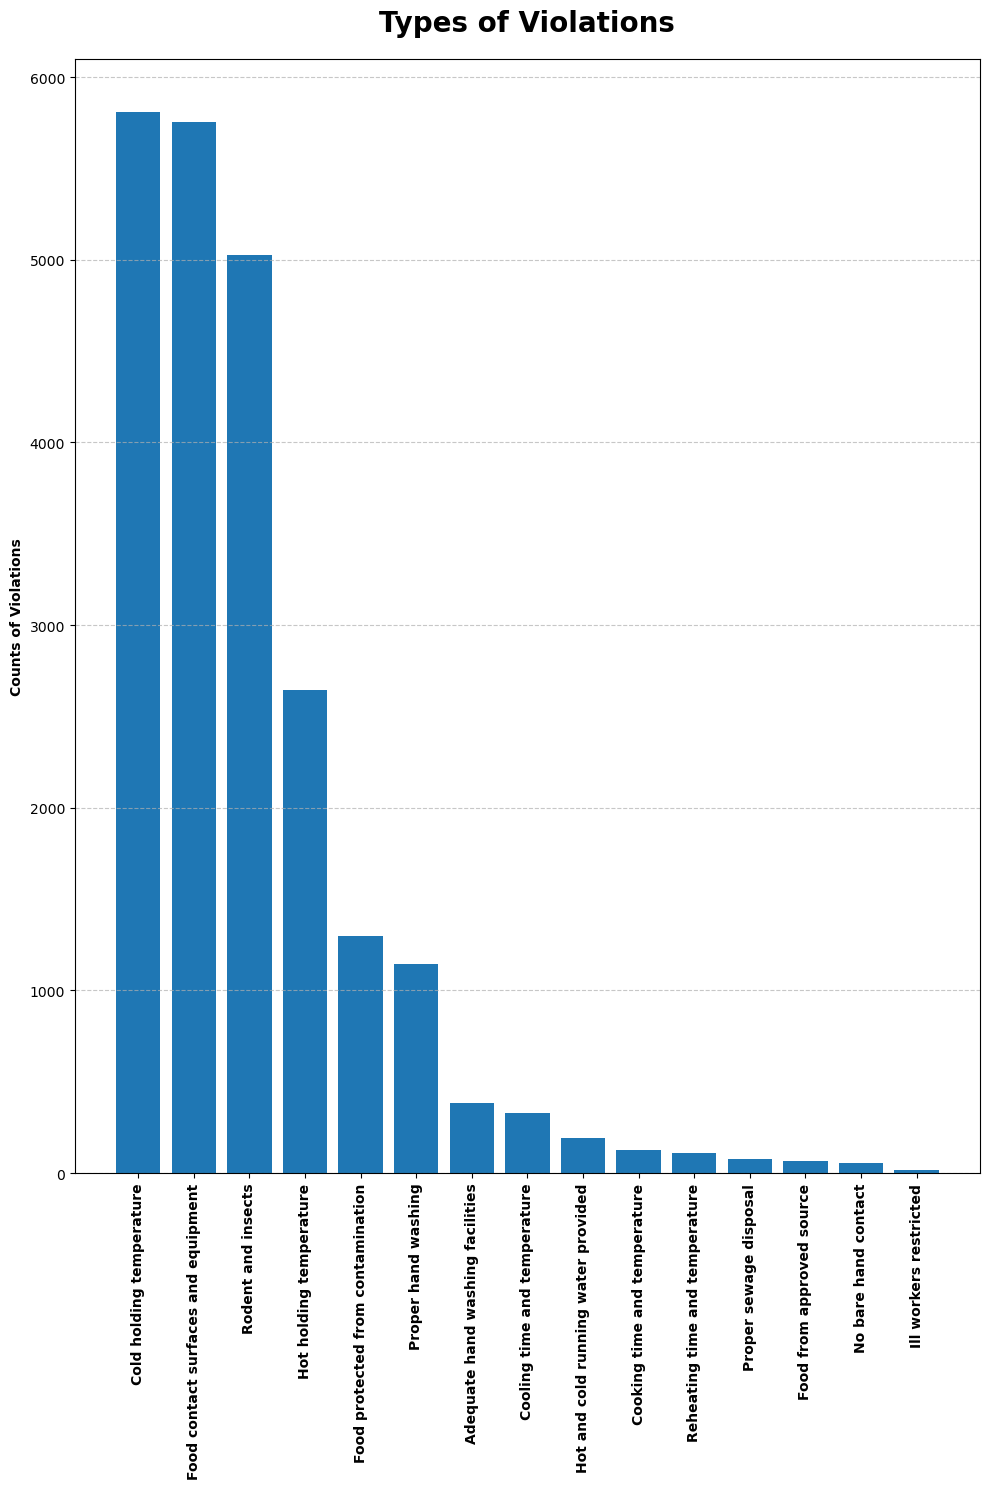

In [198]:
#Visualizing violation in a Bar chart
data_to_plot=restaurant_data[list_of_inspection_parameters].sum().sort_values(ascending=False)
data_to_plot.index=data_to_plot.index.str.replace('_', ' ', regex=True)
plt.figure(figsize=(10, 15))
plt.bar(x=data_to_plot.index, height=data_to_plot)
plt.ylabel('Counts of Violations',fontsize= 10, fontweight= 1000)
plt.title('Types of Violations', fontdict={'fontsize': 20, 'fontweight': 700, }, pad=20)
plt.xticks(rotation='vertical',fontsize= 10, fontweight= 1000)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [110]:
restaurants_in_violation=restaurant_data.groupby(by=['Year','Month'],group_keys=True)['Violantion_observed'].apply(lambda x: x==0)
percent_in_violation=restaurants_in_violation.groupby(level=[0,1],as_index=True).agg(lambda x: x.sum()*100/len(x))
percent_in_violation.tail(14)

Year  Month
2022  10       49.074074
      11       55.118110
      12       54.497354
2023  01       48.387097
      02       49.751244
      03       58.128079
      04       63.392857
      05       64.444444
      06       58.598726
      07       47.000000
      08       56.140351
      09        0.000000
      10       67.346939
      11       80.000000
Name: Violantion_observed, dtype: float64

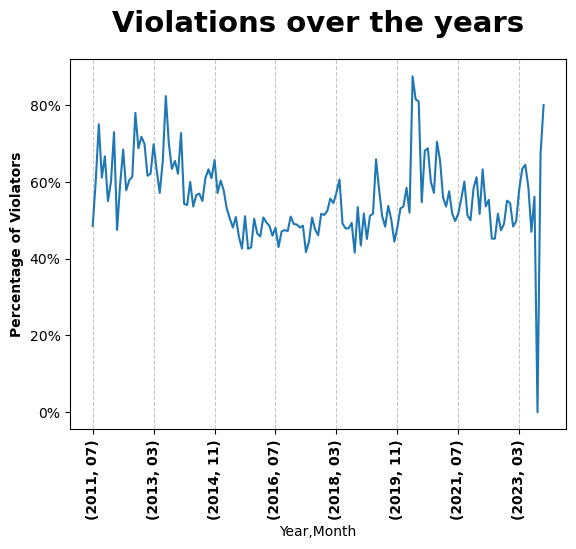

In [220]:
percent_in_violation.plot()
plt.ylabel('Percentage of Violators',fontsize= 10, fontweight= 1000)
plt.title('Violations over the years', fontdict={'fontsize': 21, 'fontweight': 700, }, pad=20)
plt.xticks(rotation='vertical',fontsize= 10, fontweight= 1000)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}%'))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

It seems that the test was a bit harder in the month of May.
The test dont seem to  get harder or easier over time. 


Lets see we can make a map of the locations of the restaurants. First we need to retrieve the longitude and latitude from the location column.

In [61]:
# To map only the latest inspection result of each eshtablishment
latest_data=restaurant_data.sort_values(by='Inspection_date', ascending=True).drop_duplicates(subset='Establishment_id', keep='last')
# Extracting latitude and longitude to make visualization of the locations
latest_data[['Longitude','Latitude']]=latest_data['Location'].str.extract('\((?P<long>.+)\s(?P<lat>.+)\)')
latest_data

,Establishment_id,Name,Category,Month,Year,Inspection_date,Inspection_results,City,State,Zip,...,Adequate_hand_washing_facilities,Rodent_and_insects,Food_contact_surfaces_and_equipment,Inspection_type,Owner,Type,Location,Violantion_observed,Longitude,Latitude
15947,788,KEITH'S TREATS AND EATS,Full Service,05,2012,2012-05-16,Compliant,LAUREL,MD,20707.0,...,0,0,0,Comprehensive,Keith Johnson,Food Establishments,POINT (-76.855981 39.092689),0,-76.855981,39.092689
27636,1989,LA CHIQUITA CARRYOUT 2,Carry-out,08,2012,2012-08-15,Compliant,HYATTSVILLE,MD,20783.0,...,0,0,0,Comprehensive,DORA ESCOBAR,Food Establishments,POINT (-76.980773 38.984794),0,-76.980773,38.984794
35686,2416,AMERICAN LEGION POST 126,Private Club,02,2014,2014-02-10,Compliant - No Health Risk,DISTRICT HTS,MD,20747.0,...,0,0,0,Comprehensive,WILLIAM MAJORS,Food Establishments,POINT (-76.871086 38.865471),0,-76.871086,38.865471
28445,1966,BREWTAINER CAFE,Carry-out,11,2014,2014-11-12,Compliant,MOUNT RAINIER,MD,20712.0,...,0,0,0,Comprehensive,LAWRENCE MARTIN,Food Establishments,POINT (-76.960749 38.937465),0,-76.960749,38.937465
10435,558,GAYLORD NATIONAL - IN-ROOM DINING,Restaurant,04,2015,2015-04-20,Critical Violations observed,NATIONAL HARBOR,MD,20745.0,...,0,0,0,Monitoring,RICHARD MORSE,Food Establishments,POINT (-77.016084 38.782417),1,-77.016084,38.782417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44571,6154,AUNTIE ANNE'S PLANET SMOOTHIE,Fast Food - Chain,11,2023,2023-11-01,Critical Violations observed,OXON HILL,MD,20745.0,...,0,1,0,Monitoring,Junius Stewart,Food Establishments,POINT (-77.001202189 38.794558672),1,-77.001202189,38.794558672
44578,794,KENNYS SUB SHOP,Carry-out,11,2023,2023-11-02,Compliant,GREENBELT,MD,20770.0,...,0,0,0,NaN,ZI ZHANG,Food Establishments,POINT (-76.853466885 38.990930928),0,-76.853466885,38.990930928
44582,1467,SUBWAY SANDWICH SHOP,Fast Food - Chain,11,2023,2023-11-02,Compliant,GREENBELT,MD,20770.0,...,0,0,0,NaN,Kamran Youssefieh,Food Establishments,POINT (-76.90881945 38.999242442),0,-76.90881945,38.999242442
44591,8408,ATOMIC WINGS,Fast Food - Local,11,2023,2023-11-02,Non-Compliant - Violations Observed,HYATTSVILLE,MD,20782.0,...,0,0,0,Monitoring,ZAKI OMAR,Food Establishments,POINT (-76.967877921 38.951121475),0,-76.967877921,38.951121475


Now we can use the Folium to make the map visualization to see where the locations are

In [348]:
# Set up the base map
latest_data=latest_data.dropna()
map_center = [latest_data['Latitude'].astype(float).mean(), latest_data['Longitude'].astype(float).mean()]
restaurant_map = folium.Map(location=map_center, zoom_start=10.3,tiles='CartoDB positron')
# Create a blue colormap using Branca
#branca.colormap.linear.RdBu_09.colors.reverse()
colormap = branca.colormap.linear.RdBu_09.scale(latest_data['Violantion_observed'].min(), latest_data['Violantion_observed'].max())

# Add markers for each restaurant, color-coded by violations
for _, row in latest_data.iterrows():
    color = colormap(row['Violantion_observed'])
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['Name']} - Violations: {row['Violantion_observed']}"
    ).add_to(restaurant_map)
    # Add a legend for violations and size/


colormap.caption = 'Number of Violations'
colormap.add_to(restaurant_map)
restaurant_map.save("restaurant_map.html")
restaurant_map

It looks like the restaurants in Balitmore Avenue near the university  are mostly in line with food safety standards
While restaurants near Suitland are not adhering to the safety standards 
University Bolevard at Langley Park also have restaurants adhering to safety standards.
